In [56]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc


from data_loader import *
from utils import *
from nn import *
from models import *
from llm import *
from llm_hf import *
import folder_manager

import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})


pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

In [3]:
create_submodel("llm_new")

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [5]:
leagues_dat = pd.read_sql("select * from overperformxg.league",config['MYSQL_STRING'])
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
1128,1131,Super Cup,Mongolia
1129,1132,AFC Challenge League,World
1130,1133,Goiano - 3,Brazil
1131,1001,CONCACAF Women U20,World


# Read All fixtures data

In [6]:
teams_dat = pd.read_sql("select * from overperformxg.team_league_map",config['MYSQL_STRING'])
teams_dat.head()

,team_name,league
0,Angers,61
1,Lille,61
2,Lyon,61
3,Marseille,61
4,Nantes,61


In [7]:
# Read player_fixture_data
complete_data = pd.read_sql("select * from overperformxg.complete_data",config['MYSQL_STRING'])

In [8]:
# Data checks
complete_data['passes_accurate'] = complete_data['passes_accurate'].astype("float64")
complete_data['fixture_date'] = pd.to_datetime(complete_data.fixture_date)
complete_data['games_rating'] = pd.to_numeric(complete_data['games_rating'])

In [9]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num','league','win','fixture_date','season','fixture_date_dt','major_position','draw','loss']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)

## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',folder_manager.encoding_path)
dat_dict[dat_dict.modeling_feature ==1]

type
numeric        45
target         10
categorical     8
datetime        3
Name: count, dtype: int64


,feature,type,modeling_feature,encoded
2,offsides,numeric,1,0
9,shots_total,numeric,1,0
10,shots_on,numeric,1,0
11,goals_total,numeric,1,0
12,goals_conceded,numeric,1,0
13,goals_assists,numeric,1,0
14,goals_saves,numeric,1,0
15,passes_total,numeric,1,0
16,passes_key,numeric,1,0
17,passes_accurate,numeric,1,0


In [ ]:
# Run Player Comparison from LLm 
#player_compare  = compare_players_from_llm(complete_data,["Giovanni Leoni","Ibrahima Konaté"],years = [2025],normalize=True)

In [10]:
# Fixture-Player data aggregated to Fixture level:
fixture_dat = calculate_fixture_stats(complete_data,['league_name'])

In [ ]:
# Sanity Check
fixture_dat['fixture_id'].value_counts(ascending = False)

In [ ]:
complete_data.head()

# Clustering Opponents

## Method 1: Decision Tree

In [ ]:
# team Cluster by tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OrdinalEncoder

target_col = 'team_goals_conceded'

# Data to train Decision Tree on
# team_class_dat = fixture_dat[['fixture_id','team','opponent','season','win']].drop_duplicates()
team_class_dat = fixture_dat[list(set(['fixture_id','team','opponent','season','league_name',
'games_rating','shots_total','shots_on','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn',
'dribble_success_rate','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','penalty_won'] + [target_col])) ].drop_duplicates()

model_cols = []#['opponent_encoded,'games_rating','shots_total','shots_on','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn','dribble_success_rate','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','penalty_won']


# Encode Non numeric features
oe = OrdinalEncoder()
team_class_dat['team_encoded'] = oe.fit_transform(team_class_dat['team'])
team_class_dat['opponent_encoded'] = oe.transform(team_class_dat.drop(columns = 'team').rename(columns={"opponent":'team'})['team']).astype("int")
team_class_dat.head()
team_class_dat['team_cluster'] = 0

for league, season in team_class_dat[['league_name', 'season']].drop_duplicates().itertuples(index=False):
    if season != np.nan:
        print(f"for season {season}, and league {league}")
        dtc = DecisionTreeClassifier(max_depth=4)
        print("Using cols: ", ['team_encoded'] + model_cols )
        model = dtc.fit(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded'] + model_cols],team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][target_col].values)
        y_pred = model.predict(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded']+ model_cols])
        team_class_dat.loc[(team_class_dat.season == season) & (team_class_dat.league_name == league),'team_cluster'] = model.predict_proba(team_class_dat[(team_class_dat.season == season) & (team_class_dat.league_name == league)][['team_encoded']+ model_cols]).max(axis = 1)

team_cluster_map = team_class_dat[['season','league_name','team','team_cluster']].drop_duplicates().reset_index(drop= True)
team_class_dat = team_class_dat.merge(team_cluster_map,left_on = ['season','league_name','opponent'],right_on = ['season','league_name','team'],how = 'left').rename(columns = {'team_cluster_y':'opponent_cluster',
                                                                                                              'team_cluster_x':'team_cluster',
                                                                                                              'team_x':'team'}).drop(columns = ['team_y'])

oe_cluster = OrdinalEncoder()
team_class_dat['opponent_cluster_encoded'] = oe_cluster.fit_transform(team_class_dat['opponent_cluster'].astype("str"))
team_class_dat['team_cluster_encoded'] = oe_cluster.fit_transform(team_class_dat['team_cluster'].astype("str"))

oe_season = OrdinalEncoder()
team_class_dat['season_ix'] = oe_season.fit_transform(team_class_dat['season'])

In [ ]:
# Check Cluster differences
team_class_dat.groupby('league_name')['opponent_cluster'].apply(lambda x: x.isna().mean())

# Bayesian Team Ability Estimation

 - team_ability: alpha ~ Normal(mu,sig^2)
 - opposition_difficulty: beta ~ Normal(mu,sig^2)

 - P(w) ~ binomial(N,alpha - beta)

In [ ]:
# Data for Binomial Model

team_class_dat_binom = team_class_dat.groupby(['season','team','team_cluster_encoded','opponent_cluster_encoded'],as_index = False).agg(wins = ('win','sum'), total_games = ('win','size'))
#Encode season
season_oe = OrdinalEncoder()
team_class_dat_binom['season_encoded'] = season_oe.fit_transform(team_class_dat_binom['season'])
team_class_dat_binom.head()

In [ ]:
# PYMC model:
# Model per season to estimate win probability given team ability, opponent cluster difficulty  

season_ix_raw = team_class_dat_binom['season']
team_ix_raw = team_class_dat_binom['team']
opps_ix_raw = team_class_dat_binom['opponent_cluster_encoded']

season_map = {x:i for i,x  in enumerate(team_class_dat_binom['season'].unique()) }
team_map = {x:i for i,x  in enumerate(team_class_dat_binom['team'].unique()) }
opps_map = {x:i for i,x  in enumerate(team_class_dat_binom['opponent_cluster_encoded'].unique()) }

season_ix = season_ix_raw.map(season_map).to_numpy()
team_ix = team_ix_raw.map(team_map).to_numpy()
opps_ix = opps_ix_raw.map(opps_map).to_numpy()

coords = {
    "team": team_class_dat_binom.team.unique(),
    "opps" : team_class_dat_binom.opponent_cluster_encoded.unique(),
    "season" : team_class_dat_binom.season.unique()
}



with pm.Model(coords = coords) as model:

    mu_team = pm.Normal("mu_team", 0, 2)
    sigma_team = pm.HalfNormal("sigma_team", 3)

    mu_opps = pm.Normal("mu_opps", 0, 3)
    sigma_opps = pm.HalfNormal("sigma_opps", 5)

    # Raw Ability:
    theta_raw = pm.Normal("theta_raw",0,1, dims = ("season","team"))
    theta_team = mu_team + theta_raw * sigma_team
    theta = pm.Deterministic("theta",theta_team - theta_team.mean(axis = 1,keepdims= True), dims = ("season","team"))

    beta_raw = pm.Normal("beta_raw",0,1,dims = ("season","opps"))
    beta_team = mu_opps + beta_raw * sigma_opps
    beta = pm.Deterministic("beta", beta_team - beta_team.mean(axis = 1,keepdims = True), dims = ("season","opps"))

    logit = theta[season_ix,team_ix] - beta[season_ix,opps_ix]
    p = pm.Deterministic("p",pm.math.sigmoid(logit))
    n = team_class_dat_binom['total_games'].values

    # Likelihood:
    p_win = pm.Binomial("p_win",p = p, n = n,observed = team_class_dat_binom['wins'].values)

    trace = pm.sample(return_inferencedata=True)




In [ ]:
# Posterior
p_summary =  pm.summary(trace)
p_summary

In [ ]:
season_filter = ['2022/2023','2024/2025','2023/2024']
teams_filter = complete_data[(complete_data.season == '2024/2025') & (complete_data.league_name == 'Premier League')]['team'].unique()#['Liverpool','Chelsea','Nottingham Forest','Manchester United','Arsenal','Manchester City','Fulham']#complete_data[(complete_data.season == '2024/2025') & (complete_data.league_name == 'Premier League')]['team'].unique()

season_dat = trace.posterior.sel(season = season_filter)
team_dat = season_dat.sel(team = teams_filter)
team_dat

In [ ]:
import plotly.express as px
import numpy as np

# Select your variable
theta = team_dat['theta'] if 'theta' in team_dat.data_vars else team_dat

chains = theta.chain.values
seasons = theta.season.values
teams = theta.team.values

# We'll build a long "plot-ready" dictionary
plot_data = {
    'value': [],
    'team': [],
    'chain': [],
    'season': []
}

# Loop over coordinates and fill the dictionary
for chain in chains:
    for season in seasons:
        for team in teams:
            y = theta.sel(chain=chain, season=season, team=team).values
            plot_data['value'].extend(y)
            plot_data['team'].extend([team]*len(y))
            plot_data['chain'].extend([chain]*len(y))
            plot_data['season'].extend([season]*len(y))

# Create the interactive KDE plot
fig = px.violin(
    plot_data,
    x='team',
    y='value',
    color='team',
    facet_row='chain',
    facet_col='season',
    box=True,          # optional: show boxplot inside violin
    points='all',      # optional: show all individual points
    hover_data=['team', 'chain', 'season']
)

fig.update_layout(height=300*len(chains), width=2000)
fig.show()

In [ ]:
team_cluster_map[team_cluster_map.league_name.str.contains("Ligue")]

In [ ]:
# Inspect the training data:


In [ ]:
# Check Number of Clusters:
# Low numbers could point to data issues
pd.pivot(team_cluster_map.groupby(['season','league_name'])['team_cluster'].nunique().reset_index(),index = 'league_name', columns = "season")

# Method 2: Kmeans

In [ ]:
auto_reload()

In [28]:
# Fixture-Player data aggregated to Fixture level:
fixture_dat = calculate_fixture_stats(complete_data,['league_name'])
fixture_dat.head()

,fixture_id,team,league_name,offsides,games_minutes,games_number,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,win,draw,loss,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,team_winner,opponent,goal_diff,week_e,year_e,season,fixture_date,l3_win,l3_draw,l3_loss,l5_win,l5_draw,l5_loss
22288,1223983,1. FC Heidenheim,Bundesliga,0.0,60.000000,16.277778,6.900000,0.055556,0.444444,5.0,3.0,2.0,2.0,0.0,312.0,4.0,222.0,17.0,1.0,8.0,118.0,58.0,19.0,8.0,4.0,9.0,15.0,3,0,0.0,0.0,0,0,0.0,73.333333,100.000000,55.874642,69.948108,1,0,0,2,2.0,0,0,0.0,0,1. FC Heidenheim,FC St. Pauli,2,2024-08-20,2024.0,2024/2025,2024-08-25 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN
22298,1223988,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.277778,7.353333,0.055556,0.444444,13.0,8.0,4.0,2.0,0.0,268.0,10.0,207.0,19.0,4.0,12.0,108.0,56.0,21.0,10.0,5.0,9.0,15.0,1,0,0.0,0.0,1,0,0.0,76.666667,83.333333,52.482401,78.213158,1,0,0,4,4.0,2,0,0.0,0,1. FC Heidenheim,FC Augsburg,4,2024-08-27,2024.0,2024/2025,2024-09-01 13:30:00,1.0,0.0,0.0,1.0,0.0,0.0
22310,1223994,1. FC Heidenheim,Bundesliga,1.0,60.466667,16.777778,6.580000,0.055556,0.444444,6.0,4.0,2.0,1.0,0.0,309.0,8.0,242.0,17.0,4.0,5.0,98.0,44.0,10.0,5.0,11.0,11.0,18.0,2,0,1.0,1.0,1,0,0.0,80.000000,75.000000,55.983738,74.652862,0,0,1,2,2.0,1,4,4.0,3,Borussia Dortmund,Borussia Dortmund,-2,2024-09-10,2024.0,2024/2025,2024-09-13 18:30:00,2.0,0.0,0.0,2.0,0.0,0.0
22332,1224005,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.666667,6.553333,0.055556,0.444444,6.0,1.0,0.0,0.0,0.0,337.0,6.0,254.0,7.0,4.0,11.0,66.0,31.0,9.0,2.0,6.0,7.0,6.0,1,0,0.0,0.0,0,0,0.0,66.666667,0.000000,49.606481,76.309731,0,0,1,0,0.0,0,3,3.0,0,SC Freiburg,SC Freiburg,-3,2024-09-17,2024.0,2024/2025,2024-09-21 13:30:00,2.0,0.0,1.0,2.0,0.0,1.0
22356,1224017,1. FC Heidenheim,Bundesliga,2.0,64.071429,17.555556,7.207143,0.055556,0.444444,12.0,6.0,2.0,2.0,0.0,359.0,14.0,270.0,20.0,3.0,8.0,126.0,69.0,12.0,7.0,4.0,10.0,10.0,4,1,0.0,0.0,0,0,0.0,76.666667,50.000000,53.020851,70.394965,1,0,0,2,2.0,1,0,0.0,0,1. FC Heidenheim,FSV Mainz 05,2,2024-09-24,2024.0,2024/2025,2024-09-28 13:30:00,1.0,0.0,2.0,2.0,0.0,2.0


In [46]:
# Time based split
min_time = fixture_dat.fixture_date.min()
max_time = fixture_dat.fixture_date.max()
split_70 = (min_time + (max_time - min_time) * .75 ).strftime("%Y-%m-%d")
print(split_70)
fixture_dat['train_split'] = np.where(fixture_dat.fixture_date <= split_70,1,0)
fixture_dat.head()


2024-06-29


,fixture_id,team,league_name,offsides,games_minutes,games_number,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,win,draw,loss,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,team_winner,opponent,goal_diff,week_e,year_e,season,fixture_date,l3_win,l3_draw,l3_loss,l5_win,l5_draw,l5_loss,train_split
22288,1223983,1. FC Heidenheim,Bundesliga,0.0,60.000000,16.277778,6.900000,0.055556,0.444444,5.0,3.0,2.0,2.0,0.0,312.0,4.0,222.0,17.0,1.0,8.0,118.0,58.0,19.0,8.0,4.0,9.0,15.0,3,0,0.0,0.0,0,0,0.0,73.333333,100.000000,55.874642,69.948108,1,0,0,2,2.0,0,0,0.0,0,1. FC Heidenheim,FC St. Pauli,2,2024-08-20,2024.0,2024/2025,2024-08-25 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0
22298,1223988,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.277778,7.353333,0.055556,0.444444,13.0,8.0,4.0,2.0,0.0,268.0,10.0,207.0,19.0,4.0,12.0,108.0,56.0,21.0,10.0,5.0,9.0,15.0,1,0,0.0,0.0,1,0,0.0,76.666667,83.333333,52.482401,78.213158,1,0,0,4,4.0,2,0,0.0,0,1. FC Heidenheim,FC Augsburg,4,2024-08-27,2024.0,2024/2025,2024-09-01 13:30:00,1.0,0.0,0.0,1.0,0.0,0.0,0
22310,1223994,1. FC Heidenheim,Bundesliga,1.0,60.466667,16.777778,6.580000,0.055556,0.444444,6.0,4.0,2.0,1.0,0.0,309.0,8.0,242.0,17.0,4.0,5.0,98.0,44.0,10.0,5.0,11.0,11.0,18.0,2,0,1.0,1.0,1,0,0.0,80.000000,75.000000,55.983738,74.652862,0,0,1,2,2.0,1,4,4.0,3,Borussia Dortmund,Borussia Dortmund,-2,2024-09-10,2024.0,2024/2025,2024-09-13 18:30:00,2.0,0.0,0.0,2.0,0.0,0.0,0
22332,1224005,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.666667,6.553333,0.055556,0.444444,6.0,1.0,0.0,0.0,0.0,337.0,6.0,254.0,7.0,4.0,11.0,66.0,31.0,9.0,2.0,6.0,7.0,6.0,1,0,0.0,0.0,0,0,0.0,66.666667,0.000000,49.606481,76.309731,0,0,1,0,0.0,0,3,3.0,0,SC Freiburg,SC Freiburg,-3,2024-09-17,2024.0,2024/2025,2024-09-21 13:30:00,2.0,0.0,1.0,2.0,0.0,1.0,0
22356,1224017,1. FC Heidenheim,Bundesliga,2.0,64.071429,17.555556,7.207143,0.055556,0.444444,12.0,6.0,2.0,2.0,0.0,359.0,14.0,270.0,20.0,3.0,8.0,126.0,69.0,12.0,7.0,4.0,10.0,10.0,4,1,0.0,0.0,0,0,0.0,76.666667,50.000000,53.020851,70.394965,1,0,0,2,2.0,1,0,0.0,0,1. FC Heidenheim,FSV Mainz 05,2,2024-09-24,2024.0,2024/2025,2024-09-28 13:30:00,1.0,0.0,2.0,2.0,0.0,2.0,0


Elbow method suggests k = 23


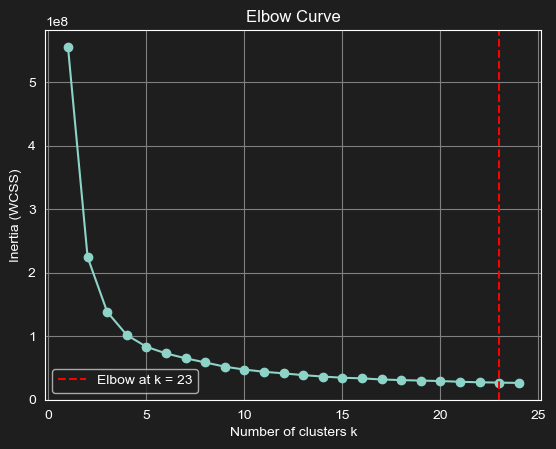

Dropping 0 rows due to nulls!


/opt/miniconda3/envs/dlcpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


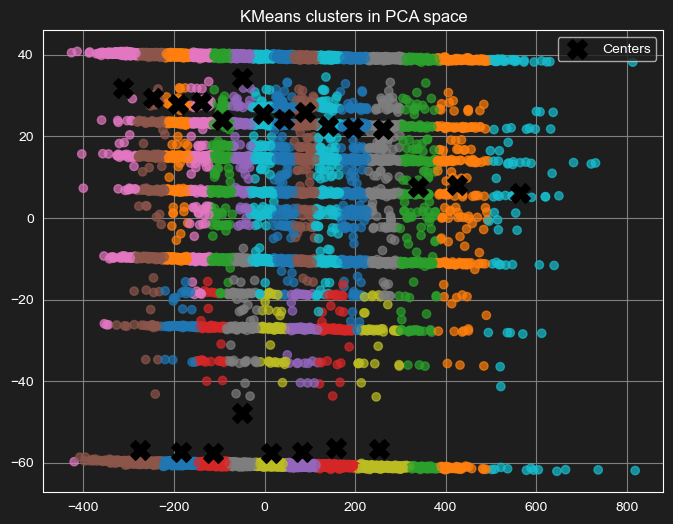

In [49]:
# Since tree classification is on a single target metric,
# I will try a K-means clustering approach to account for all data to cluster teams to get ~10-15 different playing styles

kmeans_cols = list(set(['games_rating','shots_total','shots_on','passes_total','passes_key','passes_accurate','duels_total','duels_won','fouls_drawn','cards_yellow','tackles_interceptions','tackles_blocks',
'dribble_success_rate','dribbles_past','target_shot_conversion_perc','duels_won_perc','pass_accuracy_perc','fouls_committed','fouls_drawn','penalty_won','penalty_commited']))

train_dat = fixture_dat[fixture_dat.train_split == 1]
train_dat = fit_kmeans(train_dat,kmeans_cols)

# Predict on all data:
# fixture_dat = fixture_dat.merge(fixture_dat[['team','fixture_id','cluster_rank']],left_on = ['fixture_id','opponent'],right_on = ['fixture_id','team'],suffixes=("","_opponent_km"),how = 'left').drop(columns = ['team_opponent_km'])
# fixture_dat = fixture_dat[fixture_dat.cluster_rank_opponent_km.notna()]
# fixture_dat['cluster_rank'] = fixture_dat['cluster_rank'].astype("int")
# fixture_dat['cluster_rank_opponent_km'] = fixture_dat['cluster_rank_opponent_km'].astype("int")
# fixture_dat.head()



In [65]:
auto_reload()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Predict Kmeans fro previous model:
test_dat = fixture_dat[fixture_dat.train_split == 0]

test_dat = predict_kmeans(test_dat,"/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/outputs/models/01_23_04_llm_new")
test_dat

,fixture_id,team,league_name,offsides,games_minutes,games_number,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,win,draw,loss,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,team_winner,opponent,goal_diff,week_e,year_e,season,fixture_date,l3_win,l3_draw,l3_loss,l5_win,l5_draw,l5_loss,train_split,cluster,cluster_rank
0,1223983,1. FC Heidenheim,Bundesliga,0.0,60.000000,16.277778,6.900000,0.055556,0.444444,5.0,3.0,2.0,2.0,0.0,312.0,4.0,222.0,17.0,1.0,8.0,118.0,58.0,19.0,8.0,4.0,9.0,15.0,3,0,0.0,0.0,0,0,0.0,73.333333,100.000000,55.874642,69.948108,1,0,0,2,2.0,0,0,0.0,0,1. FC Heidenheim,FC St. Pauli,2,2024-08-20,2024.0,2024/2025,2024-08-25 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0,1,7
1,1223988,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.277778,7.353333,0.055556,0.444444,13.0,8.0,4.0,2.0,0.0,268.0,10.0,207.0,19.0,4.0,12.0,108.0,56.0,21.0,10.0,5.0,9.0,15.0,1,0,0.0,0.0,1,0,0.0,76.666667,83.333333,52.482401,78.213158,1,0,0,4,4.0,2,0,0.0,0,1. FC Heidenheim,FC Augsburg,4,2024-08-27,2024.0,2024/2025,2024-09-01 13:30:00,1.0,0.0,0.0,1.0,0.0,0.0,0,1,7
2,1223994,1. FC Heidenheim,Bundesliga,1.0,60.466667,16.777778,6.580000,0.055556,0.444444,6.0,4.0,2.0,1.0,0.0,309.0,8.0,242.0,17.0,4.0,5.0,98.0,44.0,10.0,5.0,11.0,11.0,18.0,2,0,1.0,1.0,1,0,0.0,80.000000,75.000000,55.983738,74.652862,0,0,1,2,2.0,1,4,4.0,3,Borussia Dortmund,Borussia Dortmund,-2,2024-09-10,2024.0,2024/2025,2024-09-13 18:30:00,2.0,0.0,0.0,2.0,0.0,0.0,0,8,9
3,1224005,1. FC Heidenheim,Bundesliga,1.0,60.000000,16.666667,6.553333,0.055556,0.444444,6.0,1.0,0.0,0.0,0.0,337.0,6.0,254.0,7.0,4.0,11.0,66.0,31.0,9.0,2.0,6.0,7.0,6.0,1,0,0.0,0.0,0,0,0.0,66.666667,0.000000,49.606481,76.309731,0,0,1,0,0.0,0,3,3.0,0,SC Freiburg,SC Freiburg,-3,2024-09-17,2024.0,2024/2025,2024-09-21 13:30:00,2.0,0.0,1.0,2.0,0.0,1.0,0,7,14
4,1224017,1. FC Heidenheim,Bundesliga,2.0,64.071429,17.555556,7.207143,0.055556,0.444444,12.0,6.0,2.0,2.0,0.0,359.0,14.0,270.0,20.0,3.0,8.0,126.0,69.0,12.0,7.0,4.0,10.0,10.0,4,1,0.0,0.0,0,0,0.0,76.666667,50.000000,53.020851,70.394965,1,0,0,2,2.0,1,0,0.0,0,1. FC Heidenheim,FSV Mainz 05,2,2024-09-24,2024.0,2024/2025,2024-09-28 13:30:00,1.0,0.0,2.0,2.0,0.0,2.0,0,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4657,1208362,Wolves,Premier League,0.0,56.875000,15.166667,7.307143,0.055556,0.444444,14.0,6.0,3.0,3.0,0.0,572.0,18.0,506.0,22.0,3.0,3.0,114.0,65.0,20.0,11.0,10.0,17.0,6.0,1,0,0.0,0.0,0,0,0.0,73.333333,77.777778,68.393273,87.264151,1,0,0,3,3.0,1,0,0.0,0,Wolves,Leicester,3,2025-04-22,2025.0,2024/2025,2025-04-26 14:00:00,3.0,0.0,0.0,5.0,0.0,0.0,0,0,3
4658,1208371,Wolves,Premier League,1.0,60.800000,16.388889,6.726667,0.055556,0.444444,5.0,1.0,0.0,0.0,0.0,333.0,3.0,282.0,29.0,2.0,6.0,89.0,48.0,19.0,8.0,8.0,7.0,11.0,0,0,0.0,0.0,0,0,0.0,61.111111,0.000000,56.170635,82.022608,0,0,1,0,0.0,0,1,1.0,1,Manchester City,Manchester City,-1,2025-04-29,2025.0,2024/2025,2025-05-02 19:00:00,3.0,0.0,0.0,5.0,0.0,0.0,0,7,14
4659,1208382,Wolves,Premier League,0.0,60.000000,16.722222,6.735714,0.055556,0.444444,8.0,3.0,0.0,0.0,0.0,501.0,8.0,440.0,17.0,1.0,9.0,94.0,48.0,26.0,10.0,7.0,11.0,8.0,1,0,0.0,1.0,0,0,0.0,63.782051,0.000000,58.156566,82.820755,0,0,1,0,0.0,0,2,2.0,1,Brighton,Brighton,-2,2025-05-06,2025.0,2024/2025,2025-05-10 14:00:00,2.0,0.0,1.0,4.0,0.0,1.0,0,13,13
4660,1208388,Wol

In [ ]:
9292/26

13.745562130177515

In [50]:
# Clusters grouped by win rate
cluster_map = train_dat.groupby(['cluster','cluster_rank'],as_index = False).agg(games = ('cluster','size'),win_perc = ("win_perc","mean") )
clusters = pd.read_csv(config['HOME_DIRECTORY'] + "/outputs/models/" +folder_manager.submodel_name + "/kmeanscluster_centers.csv").reset_index().rename(columns = {'index':'cluster'})
clusters = clusters.merge(cluster_map,how = 'left').drop(columns = ['cluster'])
print(f"Number of clusters: {clusters.shape[0]}")
clusters = pd.concat([clusters.iloc[:,-3:], clusters.iloc[:,:-3]],axis = 1).sort_values('cluster_rank')
clusters['cluster_rank'] = clusters['cluster_rank'].astype("int")
clusters.sort_values('cluster_rank',ascending = True,inplace = True)
clusters

Number of clusters: 23


,cluster_rank,games,win_perc,cards_yellow,dribble_success_rate,dribbles_past,duels_total,duels_won,duels_won_perc,fouls_committed,fouls_drawn,games_rating,pass_accuracy_perc,passes_accurate,passes_key,passes_total,penalty_commited,penalty_won,shots_on,shots_total,tackles_blocks,tackles_interceptions,target_shot_conversion_perc
22,1,102,0.754902,0.990196,73.628813,6.588235,85.911765,45.000000,56.348148,8.333333,9.500000,7.246292,89.511490,741.431373,13.794118,811.470588,0.068627,0.147059,6.519608,12.549020,1.490196,6.686275,67.636166
3,2,332,0.698795,1.234940,74.785157,7.042169,88.099398,45.608434,56.384898,9.000000,9.795181,7.173148,88.215882,643.686747,13.996988,714.442771,0.066265,0.174699,6.608434,13.150602,1.629518,7.448795,69.279200
16,3,620,0.651613,1.579032,74.479128,7.617742,94.314516,48.704839,55.537524,10.564516,10.798387,7.068834,85.678576,527.327419,13.150000,599.920968,0.100000,0.154839,6.333871,12.414516,2.050000,8.477419,82.673259
6,4,473,0.615222,1.435518,74.908438,7.479915,94.558140,48.809725,55.385643,10.209302,10.458774,7.091948,86.678083,581.107822,13.617336,654.539112,0.103594,0.171247,6.340381,12.665962,1.733615,8.232558,68.481619
0,5,803,0.596513,1.681196,74.766821,7.850560,96.513076,49.303861,54.817891,10.879203,11.094645,7.013094,84.487036,478.669988,11.877958,552.697385,0.105853,0.145704,5.679950,11.528020,2.185554,8.449564,82.842925
20,6,916,0.542576,1.792576,75.270970,7.858079,98.127729,49.975983,54.440918,11.378821,11.450873,6.979945,83.468998,439.459607,11.712882,514.150655,0.140830,0.170306,5.648472,11.453057,2.319869,8.786026,83.142004
13,7,1047,0.520535,1.841452,74.974581,8.223496,99.851958,50.396371,54.272533,11.974212,11.570201,6.943886,82.300118,404.072588,11.067813,479.151862,0.123209,0.142311,5.265521,10.840497,2.364852,9.244508,86.434602
5,8,1260,0.507143,2.134127,74.798256,9.061111,104.438889,51.857937,53.211563,12.879365,11.558730,6.868753,76.984047,273.283333,9.016667,349.236508,0.151587,0.151587,4.672222,9.325397,3.184921,10.182540,84.197090
4,9,1020,0.494118,2.284593,74.841886,9.242395,105.286555,51.244357,52.586481,13.225711,11.341511,6.820162,72.943874,205.770363,7.509323,279.924436,0.155054,0.167812,4.108930,8.079490,3.735034,10.657507,87.942972
15,10,295,0.491525,2.650847,72.435557,10.054237,102.105085,48.610169,51.964774,13.284746,9.993220,6.759702,66.152452,125.318644,5.555932,190.654237,0.183051,0.166102,3.322034,6.444068,4.562712,10.738983,91.457627


In [ ]:
fixture_dat.query("league_name == 'Premier League' and cluster_rank == 4").set_index('year_e').sort_index()[['team','opponent','cluster_rank_opponent_km']]['team'].value_counts(normalize = True, ascending = False)

In [ ]:
#Binomial data for Bayesian Model:
model_dat = fixture_dat.groupby(['season','team','cluster_rank_opponent_km'],as_index = False).agg(win = ('win','sum'),games_played = ('win','size'))
model_dat.head()

In [ ]:
# Cluster feature distribution
px.violin(fixture_dat,y = 'target_shot_conversion_perc',x = 'cluster_rank')

In [ ]:
px.violin(fixture_dat[(fixture_dat.team.isin(['Liverpool','Crystal Palace']) ) & (fixture_dat.fixture_date >= '2025-03-01')],x = 'cluster_rank',color = 'team')

In [ ]:
fixture_dat[(fixture_dat.team == 'Liverpool') & (fixture_dat.opponent == 'Crystal Palace')][['fixture_date','team','cluster_rank','cluster_rank_opponent_km','opponent']].sort_values('fixture_date',ascending = False)

In [ ]:
fixture_dat[(fixture_dat.cluster_rank  == 7) & (fixture_dat.league_name == 'Premier League') & (fixture_dat.fixture_date >= '2025-03-01')]

In [ ]:
# Idea:
# Given Team and opponent, can we infer the playing style i.e. cluster 

# Lets try
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# split
fixture_dat


In [ ]:
auto_reload()
config['HOME_DIRECTORY'] + "/outputs/models/" + folder_manager.submodel_name

In [ ]:
trace_new = bayesian_team_ability_model(model_dat,'team','cluster_rank_opponent_km','season','win','games_played',config['HOME_DIRECTORY'] + "/outputs/models/" +folder_manager.submodel_name,"summary")

In [ ]:
complete_data[complete_data.team == 'Liverpool'][['fixture_id','team','opponent','season']]

In [ ]:
post_new_sum = az.summary(trace_new)

In [ ]:
model_dat.head()

In [ ]:
# test prediction:
test_dat = pd.DataFrame({"team":["Liverpool"] * 5,"opponent_cluster":[1,2,4,5,10],"season":["2024/2025"] * 5})
new_pred = predict_bayesian_team_ability(test_dat,config['HOME_DIRECTORY'] + "/outputs/models/" + folder_manager.submodel_name,"team","opponent_cluster","season")

In [ ]:
new_pred

In [ ]:
fixture_dat[fixture_dat['team'] == 'Crystal Palace'][['fixture_date','cluster_rank','opponent']].sort_values('fixture_date',ascending = False)

In [ ]:
liverpool_theta_new = post_new.sel(team = 'Liverpool')
liverpool_theta_new

In [ ]:
import plotly.express as px
import numpy as np

# Select your variable
theta = team_dat['theta'] if 'theta' in team_dat.data_vars else team_dat
theta_stacked = theta.stack(sample = ("chain","draw"))

#chains = theta.chain.values
seasons = theta.season.values
teams = theta.team.values

# We'll build a long "plot-ready" dictionary
plot_data = {
    'value': [],
    'team': [],
    'season': []
}

# Loop over coordinates and fill the dictionary
#for chain in chains:
for season in seasons:
    for team in teams:
        y = theta_stacked.sel( season=season, team=team).values
        plot_data['value'].extend(y)
        plot_data['team'].extend([team]*len(y))
        #plot_data['chain'].extend([chain]*len(y))
        plot_data['season'].extend([season]*len(y))

# Create the interactive KDE plot
fig = px.violin(
    plot_data,
    x='team',
    y='value',
    color='team',
    facet_col='season',
    box=True,          # optional: show boxplot inside violin
    points='all',      # optional: show all individual points
    hover_data=['team', 'season']
)

fig.update_layout(height=300*4, width=2000)
fig.show()

In [ ]:
fixture_dat = calculate_fixture_stats(complete_data,['games_position'])

In [ ]:
filter = 'games_position.isin(["M","D"])' #'fixture_id.notna()' # 

target = 'team_goals_scored'
col_subset = [['win','games_rating','shots_total','shots_on','goals_total','goals_saves','duels_won']]

cor_dat = fixture_dat.query(filter).corr(numeric_only=True)[[target]]
cor_dat.drop(target,inplace = True)

sorted_cols = cor_dat.sort_values(target,ascending = False).index.to_list()

fig, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(cor_dat.loc[sorted_cols],cmap = 'coolwarm',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation =75)
fig.show()

# Player Model

In [ ]:
find_player(complete_data,player_name="Leoni")

In [ ]:
auto_reload()

In [18]:
complete_data = complete_data.iloc[:,:-4]

In [ ]:
# After creating Fixtures dat
# Fixtures clusters to join 
fixture_team_cluster = fixture_dat[['fixture_id','team','cluster_rank','cluster_rank_opponent_km']].drop_duplicates()
complete_data = complete_data.merge(fixture_team_cluster,on = ['fixture_id','team'],how = 'left')
#complete_data['cluster_rank_opponent_km'] = complete_data['cluster_rank_opponent_km'].astype("float").astype("int").astype("str")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [21]:
complete_data.shape

(484054, 71)

In [22]:
complete_data.head()

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,fixture_date,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,fixture_date_dt,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e,season,outcome_num,win,draw,loss,league,league_id,league_name,month_name_e_ix,day_of_week_name_e_ix,league_name_ix,cluster_rank,cluster_rank_opponent_km
0,963,Lukáš Hrádecký,NaN,90.0,1,G,8.9,1,0,NaN,NaN,NaN,0,NaN,6.0,39.0,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,1.0,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,NaN,74.358974,2021-08-21,2021.0,2021-08-01,August,5.0,Saturday,2021-08-17,2021/2022,2,1,0,0,78,78,Bundesliga,1.070007,1.132986,1.122844,NaN,NaN
1,152654,Jeremie Frimpong,NaN,90.0,30,D,7.0,0,0,NaN,NaN,NaN,0,NaN,NaN,32.0,1.0,27.0,2.0,NaN,NaN,10.0,5.0,2.0,1.0,1.0,2.0,1.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00,Bayer Leverkusen,Bayer Leverkusen,win,50.0,NaN,50.000000,84.375000,2021-08-21,2021.0,2021-08-01,August,5.0,Saturday,2021-08-17,2021/2022,2,1,0,0,78,78,Bundesliga,1.070007,1.132986,1.122844,NaN,NaN
2,48119,Odilon Kossounou,NaN,90.0,6,D,7.6,0,0,NaN,NaN,NaN,0,NaN,NaN,57.0,1.0,46.0,2.0,1.0,2.0,6.0,5.0,NaN,NaN,1.0,1.0,NaN,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,83.333333,80.701754,2021-08-21,2021.0,2021-08-01,August,5.0,Saturday,2021-08-17,2021/2022,2,1,0,0,78,78,Bundesliga,1.070007,1.132986,1.122844,NaN,NaN
3,972,Jonathan Tah,NaN,90.0,4,D,7.2,0,0,NaN,NaN,NaN,0,1.0,NaN,54.0,1.0,51.0,2.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,2.0,0,0,NaN,NaN,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00,Bayer Leverkusen,Bayer Leverkusen,win,NaN,NaN,60.000000,94.444444,2021-08-21,2021.0,2021-08-01,August,5.0,Saturday,2021-08-17,2021/2022,2,1,0,0,78,78,Bundesliga,1.070007,1.132986,1.122844,NaN,NaN
4,530,Mitchel Bakker,NaN,90.0,5,D,8.2,0,0,1.0,1.0,1.0,0,1.0,NaN,46.0,1.0,40.0,1.0,NaN,1.0,10.0,6.0,4.0,3.0,NaN,2.0,2.0,1,0,NaN,1.0,0,0,NaN,719361,4,4.0,2,0,0.0,0,Borussia Monchengladbach,2021-08-21 16:30:00,Bayer Leverkusen,Bayer Leverkusen,win,75.0,100.0,60.000000,86.956522,2021-08-21,2021.0,2021-08-01,August,5.0,Saturday,2021-08-17,2021/2022,2,1,0,0,78,78,Bundesliga,1.070007,1.132986,1.122844,NaN,NaN


In [27]:
complete_data[complete_data.fixture_date >= datetime.today() - timedelta(days = 50)]

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accurate,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,fixture_date,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,fixture_date_dt,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e,season,outcome_num,win,draw,loss,league,league_id,league_name,month_name_e_ix,day_of_week_name_e_ix,league_name_ix,cluster_rank,cluster_rank_opponent_km
483414,280,Alisson,NaN,90.0,1,G,7.3,0,0,NaN,NaN,NaN,0,0.0,1.0,47.0,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.0,1378993,1,1.0,0,0,0.0,0,Arsenal,2025-08-31 15:30:00,Liverpool,Liverpool,win,NaN,NaN,NaN,80.851064,2025-08-31,2025.0,2025-08-01,August,6.0,Sunday,2025-08-26,2025/2026,2,1,0,0,39,39,Premier League,1.070007,1.110666,1.165663,9.0,11.0
483415,1096,Dominik Szoboszlai,NaN,90.0,8,D,8.2,0,0,1.0,1.0,1.0,0,0.0,NaN,52.0,1.0,47.0,2.0,NaN,1.0,4.0,3.0,NaN,NaN,1.0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1378993,1,1.0,0,0,0.0,0,Arsenal,2025-08-31 15:30:00,Liverpool,Liverpool,win,NaN,100.0,75.000000,90.384615,2025-08-31,2025.0,2025-08-01,August,6.0,Sunday,2025-08-26,2025/2026,2,1,0,0,39,39,Premier League,1.070007,1.110666,1.165663,9.0,11.0
483416,1145,Ibrahima Konaté,NaN,79.0,5,D,7.2,0,0,NaN,NaN,NaN,0,0.0,NaN,44.0,NaN,44.0,1.0,2.0,NaN,5.0,2.0,NaN,NaN,NaN,NaN,2.0,0,0,NaN,NaN,0,0,NaN,1378993,1,1.0,0,0,0.0,0,Arsenal,2025-08-31 15:30:00,Liverpool,Liverpool,win,NaN,NaN,40.000000,100.000000,2025-08-31,2025.0,2025-08-01,August,6.0,Sunday,2025-08-26,2025/2026,2,1,0,0,39,39,Premier League,1.070007,1.110666,1.165663,9.0,11.0
483417,290,Virgil van Dijk,NaN,90.0,4,D,7.9,1,0,NaN,NaN,NaN,0,0.0,NaN,81.0,NaN,73.0,NaN,3.0,1.0,3.0,2.0,1.0,1.0,NaN,1.0,NaN,0,0,NaN,NaN,0,0,NaN,1378993,1,1.0,0,0,0.0,0,Arsenal,2025-08-31 15:30:00,Liverpool,Liverpool,win,100.0,NaN,66.666667,90.123457,2025-08-31,2025.0,2025-08-01,August,6.0,Sunday,2025-08-26,2025/2026,2,1,0,0,39,39,Premier League,1.070007,1.110666,1.165663,9.0,11.0
483418,206254,Miloš Kerkez,NaN,90.0,6,D,7.9,0,0,NaN,NaN,NaN,0,0.0,NaN,29.0,NaN,24.0,3.0,1.0,NaN,9.0,7.0,NaN,NaN,NaN,2.0,NaN,0,0,NaN,NaN,0,0,NaN,1378993,1,1.0,0,0,0.0,0,Arsenal,2025-08-31 15:30:00,Liverpool,Liverpool,win,NaN,NaN,77.777778,82.758621,2025-08-31,2025.0,2025-08-01,August,6.0,Sunday,2025-08-26,2025/2026,2,1,0,0,39,39,Premier League,1.070007,1.110666,1.165663,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484049,153066,Fabio Carvalho,NaN,11.0,14,M,6.7,0,1,NaN,NaN,NaN,0,0.0,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1379013,1,1.0,1,3,3.0,2,Fulham,2025-09-20 19:00:00,Fulham,Brentford,loss,NaN,NaN,NaN,75.000000,2025-09-20,2025.0,2025-09-01,September,5.0,Saturday,2025-09-16,2025/2026,1,0,0,1,39,39,Premier League,1.139703,1.132986,1.165663,NaN,NaN
484050,61742,Hákon Rafn Valdimarsson,NaN,NaN,12,G,NaN,0,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1379013,1,1.0,1,3,3.0,2,Fulham,2025-09-20 19:00:00,Fulham,Brentford,loss,NaN,NaN,NaN,NaN,2025-09-20,2025.0,2025-09-01,September,5.0,Saturday,2025-09-16,2025/2026,1,0,0,1,39,39,Premier League,1.139703,1.132986,1.165663,NaN,NaN
484051,44871,Aaron Hickey,NaN,NaN,2,D,NaN,0,1,NaN,Na

In [ ]:
# average data points per player:
complete_data.groupby('player_name')['player_name'].agg("count").hist(bins = 200)

In [ ]:
# Maybe low count per player-match
# Lets say how does florian Wirtz fair in terms of key passes in terms of opponent clusters
metric = 'goals_assists'
flo = complete_data.query("player_name == 'Florian Wirtz' and games_minutes > 20 and cluster_rank_opponent_km.notna()")[[metric,'cluster_rank_opponent_km']].fillna(0)

flo["cluster_rank_opponent_km"] = pd.to_numeric(flo["cluster_rank_opponent_km"], errors="coerce")
flo = flo.dropna(subset=["cluster_rank_opponent_km"])
flo["cluster_rank_opponent_km"] = flo["cluster_rank_opponent_km"].astype(int)
cluster_sort = sorted(flo['cluster_rank_opponent_km'].unique())

fig = px.violin(
    flo,
    x=metric,
    color="cluster_rank_opponent_km",
    category_orders={"cluster_rank_opponent_km": cluster_sort},
    title="Florian Wirtz: Key Passes vs Opponent Clusters"
)
fig.show()

In [ ]:
complete_data.groupby('team').agg(null_opps_clusters = ("cluster_rank_opponent_km",lambda x: np.mean(x.isna()) )).sort_values("null_opps_clusters",ascending=False).query('null_opps_clusters > .10')

In [ ]:
all_defenders_2025 = complete_data[(complete_data.major_position == 'D')]['player_name'].unique()
all_defenders_2025

In [ ]:
defenders_compare = compare_players(complete_data,all_defenders_2025,seasons = ["2024/2025"],transpose = False)
defenders_compare.head()

In [ ]:
defenders_compare.columns

In [ ]:
complete_data.head()

In [ ]:
per_90_cols = [col for col in defenders_compare.columns if "per_90" in col]
attack_per_90_cols  = ['total_shots_per_90','shots_on_target_per_90','goals_scored_per_90','assists_per_90',
                       'fouls_drawn_per_90','attempted_dribbles_per_90','successful_dribbles_per_90',
                       'dribble_success_rate_per_90','duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90']
defense_per_90_cols = ['yellow_cards_per_90','red_cards_per_90','fouls_drawn_per_90','fouls_committed_per_90',
                       'dribbled_past_per_90', 'total_tackles_per_90','blocks_per_90','interceptions_per_90',
                       'duels_contested_per_90','duels_won_per_90','duels_won_percentage_per_90','penalties_committed_per_90']
pass_per_90_cols = [ 'total_passes_per_90','key_passes_per_90', 'average_passes_accurate_per_90','average_pass_accuracy_per_90']

In [ ]:
defenders_compare.head()

In [ ]:
# Calculate Clusters:
filter = 'total_minutes_played  > 1000'
defense_cluster = 'defense_cluster'
pass_cluster = 'pass_cluster'
defenders_compare_w_cluster = fit_kmeans(defenders_compare.query(filter),defense_per_90_cols,12,defense_cluster)
defenders_compare_w_cluster = fit_kmeans(defenders_compare_w_cluster.query(filter),pass_per_90_cols,None,pass_cluster)

In [ ]:
[col for col in complete_data.columns if 'position' in col]

In [ ]:
find_player(complete_data,player_name="Virgil van")

In [ ]:
defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains("William Saliba")]

In [ ]:
defense_cluster

In [ ]:
clusters = defenders_compare_w_cluster[defenders_compare_w_cluster.player_name.str.contains('William Saliba')][[defense_cluster,pass_cluster]].values
clusters
#defenders_compare_w_cluster[defenders_compare_w_cluster[cluster_name].isin(defenders_compare_w_cluster[condition][cluster_name])].sort_values("average_rating",ascending = False)

In [ ]:
folder_manager.llm_code_path

In [ ]:
question = "How are you doing?"
question_no_spec = re.sub(r"[?.,;:]","",question)
split_words = [word for word in question_no_spec.split(" ")]
split_words

In [ ]:
complete_data.columns

In [ ]:
defenders_compare_w_cluster[(defenders_compare_w_cluster.player_name.isin(["Mike Eerdhuijzen","Giovanni Leoni","Nikola Milenković","Marc Guéhi","Ladislav Krejčí"]))][['player_name'] + [col for col in defenders_compare.columns if "per_90" in col]].T

In [ ]:
complete_data.columns

In [ ]:
plot_from_llm(complete_data[complete_data.player_name == 'Olivier Boscagli'],"Plot Average games_rating with error cloud by month_e faceted by team")

In [ ]:
plot_continuous_trend(complete_data[complete_data.player_name == 'Emmanuel Agbadou'],"month_e","games_rating")

In [ ]:
filter_query = 'major_position.isin(["M"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'
agg_fun = "mean"
rank_cutoff = 20

# configs 
min_appearance = 40

dribble_dat_g = complete_data.query(filter_query).reset_index().fillna(0).groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,agg_fun)).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=complete_data.query(filter_query)[complete_data.query(filter_query).player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['ATTACK_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded','games_rating']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)

In [ ]:
complete_data.head()

In [ ]:
sns.pairplot(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']])

In [ ]:
complete_data.columns

In [ ]:
config['PASSING_COLS'] + config['DEFENSE_COLS']

In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data.query(filter_query)[list(set(config['PASSING_COLS'] + config['DEFENSE_COLS'] ))],
                                                    complete_data.query(filter_query)['win'],
                                                    stratify=complete_data.query(filter_query)['win'],
                                                    random_state=33)


In [ ]:
create_submodel("catboost")

In [ ]:
output_path

In [ ]:
model = run_model_with_fs_tune(X_train, X_test, y_train, y_test,dat_dict,'catboost',output_path=folder_manager.output_path)

In [ ]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

In [ ]:
train_loader.dataset.X_numeric_tensor.shape

In [ ]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [ ]:
model.eval()

In [ ]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [ ]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [ ]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[complete_data.games_position == 'F'][list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),
                                                    complete_data[complete_data.games_position == 'F']['win'],
                                                    stratify=complete_data['win'],
                                                    random_state=33)

In [ ]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005)

In [ ]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


In [ ]:
pred_proba.squeeze(1)

In [ ]:
from validations import *


test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_proba = torch.softmax(output,dim =1)
        pred_class = torch.argmax(output, dim = 1)


discrete_evaluations(y_test,pred_class,pred_proba.squeeze(1),classification_type="Binary",model_path= folder_manager.output_path)

In [ ]:
test_fixtures = get_team_fixtures("Liverpool",2)

In [ ]:
test_fixtures

In [ ]:
player_stat_url = "https://v3.football.api-sports.io/fixtures/players?fixture={}".format(1035045)
fixture_dat = requests.get(player_stat_url,headers=headers_api_sport)

In [ ]:
pd.json_normalize(pd.json_normalize(fixture_dat.json()['response']))['players'][0]

In [ ]:
fixture_dat_expanded = pd.concat([pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])[['player.id','player.name']],pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])['statistics']).rename(columns = {0:"player_stats"})['player_stats'])],axis = 1)

In [ ]:
fixtures_stat = complete_data.groupby(['fixture_id','team'],as_index=False).agg(n_opponent = ('opponent','count'),total_passes = ('passes_total','sum')).sort_values('fixture_id',ascending= False)

In [ ]:
fixtures_stat

In [ ]:
complete_data[complete_data.fixture_id == 1376437][['team','opponent']]

In [ ]:
teams_dat[teams_dat.team_name.str.contains("Tels")]

In [ ]:
angers = pd.read_parquet(home_dir + "/data/Fixtures/angers_2024.parquet")

In [ ]:
angers['fixture_date'] = pd.to_datetime(angers['fixture_date'])

In [ ]:
angers['fixture_date']